<a href="https://colab.research.google.com/github/Lou1sM/RIMC_22_CV/blob/main/RIMC_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install -q jmd_imagescraper
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
!rm -r '/content/images/'

In [58]:
google_image_query = 'chuck norris' # replace this with your own query


from pathlib import Path
root = Path().cwd()/"images"
from jmd_imagescraper.core import * 

image_save_dir = google_image_query.replace(' ','_')

_=duckduckgo_search(root, image_save_dir, google_image_query, max_results=10,img_type=ImgType.All, img_layout=ImgLayout.All, img_color=ImgColor.All)
_=duckduckgo_search(root, 'neg_images', 'random images', max_results=10)

Duckduckgo search: chuck norris


Duckduckgo search: random images


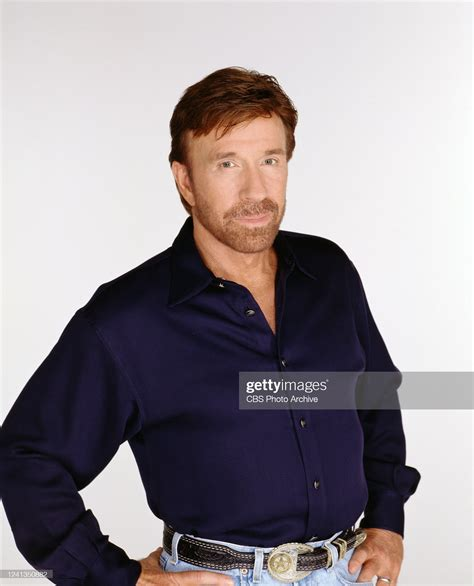

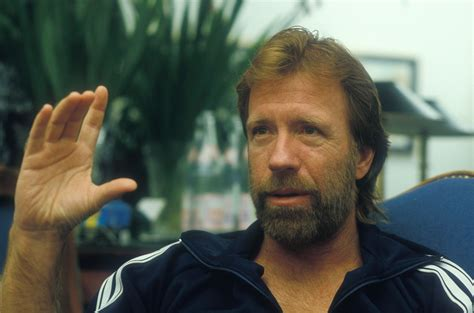

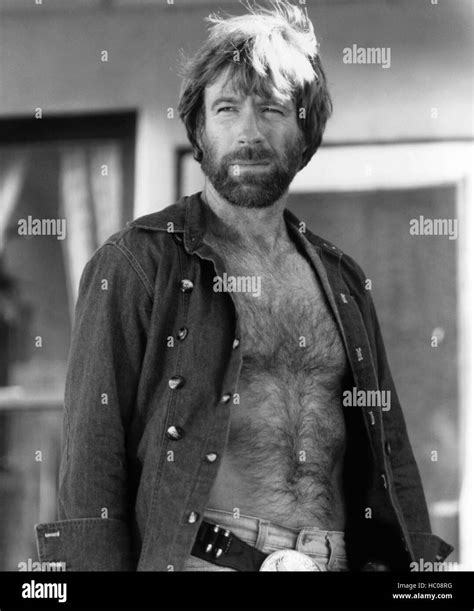

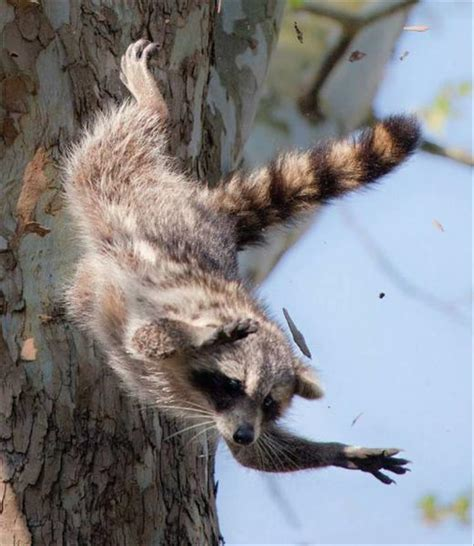

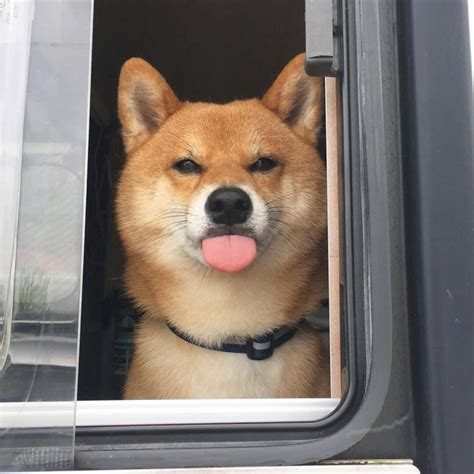

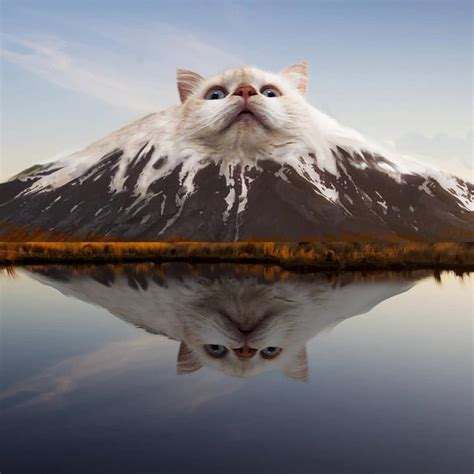

In [59]:
#View three images that you downloaded, and three random other images that will be in the negative class


from IPython.display import Image, display
from random import shuffle
import os


all_fns = os.listdir(os.path.join('/content/images/',image_save_dir))
shuffle(all_fns)
for fn in all_fns[:3]:
  fpath = os.path.join('/content/images',image_save_dir,fn)
  display(Image(fpath))

all_neg_fns = os.listdir('/content/images/neg_images')
shuffle(all_neg_fns)
for fn in all_neg_fns[:3]:
  fpath = os.path.join('/content/images/neg_images',fn)
  display(Image(fpath))


In [ ]:
!pip install tensorflow-gpu

In [60]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf

batch_size = 64
image_size = 224,224

base_model=tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(3e-4), loss='binary_crossentropy',metrics=['accuracy'])

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/images/",
    validation_split=0.1,
    subset='training',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/images/",
    validation_split=0.1,
    subset='validation',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

model.fit(augmented_train_ds,epochs=30,validation_data=val_ds)

Found 20 files belonging to 2 classes.
Using 18 files for training.
Found 20 files belonging to 2 classes.
Using 2 files for validation.
Epoch 1/30
1/1 [==============================] - 9s 9s/step - loss: 8.1820 - accuracy: 0.4444 - val_loss: 112.6264 - val_accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 43.5593 - accuracy: 0.5556 - val_loss: 112.6783 - val_accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 45.0929 - accuracy: 0.5556 - val_loss: 67.4272 - val_accuracy: 0.0000e+00
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 25.5448 - accuracy: 0.5556 - val_loss: 5.5025 - val_accuracy: 0.5000
Epoch 5/30
1/1 [==============================] - 2s 2s/step - loss: 1.7500 - accuracy: 0.7778 - val_loss: 3.5272e-20 - val_accuracy: 1.0000
Epoch 6/30
1/1 [==============================] - 2s 2s/step - loss: 16.2148 - accuracy: 0.4444 - val_loss: 2.3100e-26 - val_accuracy: 1.0000
Epoch 7/30
1

Duckduckgo search: dogs


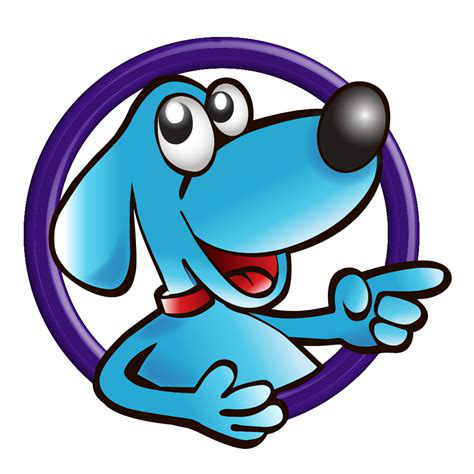

1/1 [==============================] - 2s 2s/step
This image is 0.00% chuck norris



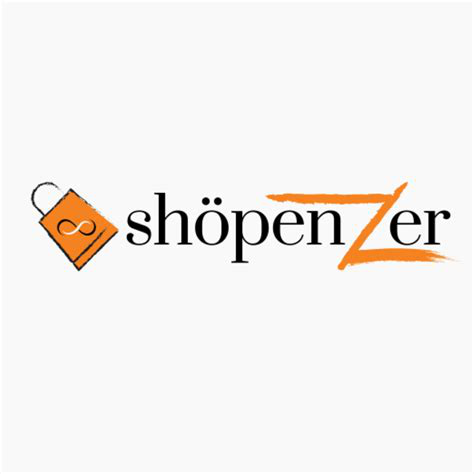

1/1 [==============================] - 0s 150ms/step
This image is 0.00% chuck norris



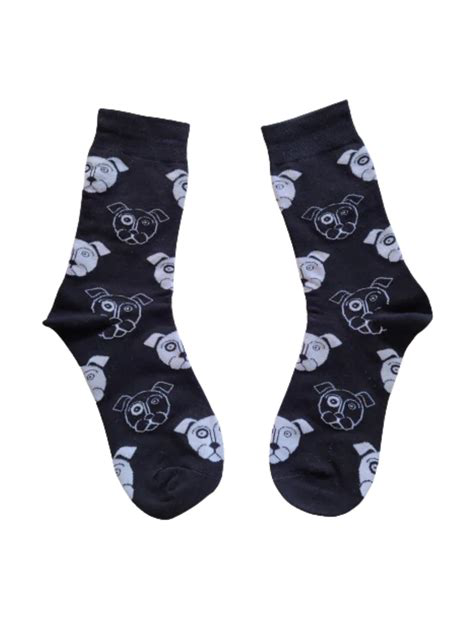

1/1 [==============================] - 0s 181ms/step
This image is 100.00% chuck norris



In [61]:
test_google_image_query = 'dogs' # replace this with your own query


from pathlib import Path
test_root = Path().cwd()/"test_images"
from jmd_imagescraper.core import * 
from IPython.display import Image, display
from random import shuffle
from PIL import Image as PImage
import numpy as np


test_image_save_dir = test_google_image_query.replace(' ','_')
import shutil
if os.path.isdir(os.path.join('/content/test_images/',test_image_save_dir)):
  shutil.rmtree(os.path.join('/content/test_images/',test_image_save_dir))

duckduckgo_search(test_root, test_image_save_dir, test_google_image_query, max_results=3,img_type=ImgType.All, img_layout=ImgLayout.All, img_color=ImgColor.All)

is_zero_means_positive = image_save_dir < 'neg_images'
all_fns = os.listdir(os.path.join('/content/test_images/',test_image_save_dir))
for fn in all_fns:
  fpath = os.path.join('/content/test_images',test_image_save_dir,fn)
  img = PImage.open(fpath)
  display(img)
  img = img.resize((224,224))

  pred_ = model.predict(np.expand_dims(np.array(img),0))[0,0]
  pred = 1-pred_ if is_zero_means_positive else pred
  print(f'This image is {pred*100:.2f}% {google_image_query}\n')


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()